In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install typing

In [ ]:
# LIBRARIES 
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
import seaborn as sns

import string
from collections import Counter, defaultdict
from enum import Enum
from itertools import chain, groupby, product

import nltk

In [ ]:
#data = pd.read_csv("/content/drive/MyDrive/MiniProject/Dataset/papers.csv")
data = pd.read_csv("/content/drive/MyDrive/papers.csv")
data.head() # DISPLAYS FIRST 5 DATA COLOUMNS
data.columns.str.match("Unnamed")
data.loc[:,~data.columns.str.match("Unnamed")]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title,abstract,id,author,journal,doi,update
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturbat...,704,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,2008-11-26
1,Polymer Quantum Mechanics and its Continuum Limit,A rather non-standard quantum representation ...,704.001,"Alejandro Corichi, Tatjana Vukasinac and Jose ...","Phys.Rev.D76:044016,2007",10.1103/PhysRevD.76.044016,2008-11-26
2,Numerical solution of shock and ramp compressi...,A general formulation was developed to repres...,704.001,Damian C. Swift,"Journal of Applied Physics, vol 104, 073536 (2...",10.1063/1.2975338,2009-02-05
3,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRAC...,704.001,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...","Astrophys.J.663:1149-1173,2007",10.1086/518646,2010-03-18
4,Fermionic superstring loop amplitudes in the p...,The pure spinor formulation of the ten-dimens...,704.001,Christian Stahn,"JHEP 0705:034,2007",10.1088/1126-6708/2007/05/034,2009-11-13
...,...,...,...,...,...,...,...
651569,Towards a Microscopic Theory for Metallic Heav...,The bias-dependent resistance R(V) of NS-junc...,supr-con/9607007,F. B. Anders and K. Gloos,"Physica B, 230-232, 437 (1997)",10.1016/S0921-4526(96)00604-7,2009-10-30
651570,Extended bound states and resonances of two fe...,The high-$T_c$ cuprates are possible candidat...,supr-con/9608003,"A. S. Blaer (1), H. C. Ren (2), and O. Tcherny...","Phys. Rev. B 55, 6035 (1997)",10.1103/PhysRevB.55.6035,2009-10-30
651571,Ginzburg-Landau-Gor'kov Theory of Magnetic osc...,We investigate de Haas-van Alphen (dHvA) osci...,supr-con/9608004,"G. M. Bruun, V. N. Nicopoulos, N. F. Johnson",PHYS REV B 56: (2) 809-825 JUL 1 1997,10.1103/PhysRevB.56.809,2016-09-08
651572,Evidence for Quasiparticle Decay in Photoemiss...,I argue that the ``gap'' recently observed at...,supr-con/9608005,R. B. Laughlin (Stanford),"Phys. Rev. Lett. 79, 1726 (1997)",10.1103/PhysRevLett.79.1726,2009-10-30


Semantic Scholar API to Obtain Metadata

In [ ]:
from typing_extensions import Literal
import requests


class SemanticScholar:

    DEFAULT_API_URL = 'https://api.semanticscholar.org/v1'
    DEFAULT_PARTNER_API_URL = 'https://partner.semanticscholar.org/v1'

    auth_header = {}

    def __init__(self,timeout: int=2,api_key: str=None,api_url: str=None) -> None:

        if api_url:
            self.api_url = api_url
        else:
            self.api_url = self.DEFAULT_API_URL

        if api_key:
            self.auth_header = {'x-api-key': api_key}
            if not api_url:
                self.api_url = self.DEFAULT_PARTNER_API_URL

        self.timeout = timeout

    def paper(self, id: str, include_unknown_refs: bool=False) -> dict:
        # Paper lookup
        # param str id: S2PaperId, DOI or ArXivId.
        data = self.get_data('paper', id, include_unknown_refs)
        return data

    def author(self, id: str) -> dict:
        data = self.get_data('author', id, False)
        return data

    def get_data(self,method: Literal['paper', 'author'],id: str ,include_unknown_refs: bool) -> dict:

        data = {}
        method_types = ['paper', 'author']
        if method not in method_types:
            raise ValueError(
                'Invalid method type. Expected one of: {}'.format(method_types)
            )

        url = '{}/{}/{}'.format(self.api_url, method, id)
        if include_unknown_refs:
            url += '?include_unknown_references=true'
        r = requests.get(url, timeout=self.timeout, headers=self.auth_header)

        if r.status_code == 200:
            data = r.json()
            if len(data) == 1 and 'error' in data:
                data = {}
        elif r.status_code == 403:
            raise PermissionError('HTTP status 403 Forbidden.')
        elif r.status_code == 429:
            raise ConnectionRefusedError('HTTP status 429 Too Many Requests.')

        return data

Obtain MetaData Information About the Paper

In [ ]:
sch = SemanticScholar(timeout=2)
# paper = sch.paper('10.1093/mind/lix.236.433')
# paper = sch.paper('10.1063/1.2975338')
# paper.keys()
# print(paper['doi'])
# for author in paper['authors']:
#   print(author['name'])
#   print(author['authorId'])

# for st in paper.keys():
#  print(st,':',paper[st]) 

# for i in range(0,len(data)): # RUN THIS AND TAB BELOW LINES TO RUN FOR ENTIRE DATASET - NOT REQUIRED
paper = sch.paper(data.doi[1])
for st in paper.keys():
  print(st,':',paper[st]) 


abstract : A rather nonstandard quantum representation of the canonical commutation relations of quantum mechanics systems, known as the polymer representation, has gained some attention in recent years, due to its possible relation with Planck scale physics. In particular, this approach has been followed in a symmetric sector of loop quantum gravity known as loop quantum cosmology. Here we explore different aspects of the relation between the ordinary Schroedinger theory and the polymer description. The paper has two parts. In the first one, we derive the polymer quantum mechanics starting from the ordinary Schroedinger theory and show that the polymer description arises as an appropriate limit. In the second part we consider the continuum limit of this theory, namely, the reverse process in which one starts from the discrete theory and tries to recover back the ordinary Schroedinger quantum mechanics. We consider several examples of interest, including the harmonic oscillator, the fr

ANALYSIS OF METADATA OF SINGLE PAPER 

In [ ]:
def data_print(paper) -> None :
  print("Basic Metadata")
  print("Title:" , str(paper['title']))
  print("Fields of Study:" , str(paper['fieldsOfStudy']))
  print("Number Cited by:" , str(paper['numCitedBy']))
  print("Number Citing:" ,str(paper['numCiting']))

data_print(paper)  

Basic Metadata
Title: Polymer Quantum Mechanics and its Continuum Limit
Fields of Study: ['Physics']
Number Cited by: 124
Number Citing: 20


Visualisations


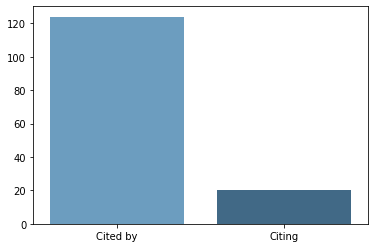

In [ ]:
#bar charts for in and out citations
def bar_chart(paper) -> None :
  dat = [paper['numCitedBy'], paper['numCiting']]
  #print("in" , dat[0])
  #print("out" ,dat[1])
  #ax = sns.barplot(x="count", y="oh no", data=dat, palette="Blues_d")

  import numpy as np                                                               
  import matplotlib.pyplot as plt

  dat = [('Cited by',paper['numCitedBy']), ('Citing',paper['numCiting'])]
  labels, ys = zip(*dat)
  ys = np.asarray(ys)
  l = np.asarray(labels)
  #ax = sns.histplot(x = labels, data = ys, palette="Blues_d")
  bx = sns.barplot(x=l ,y= ys, palette="Blues_d")

bar_chart(paper)

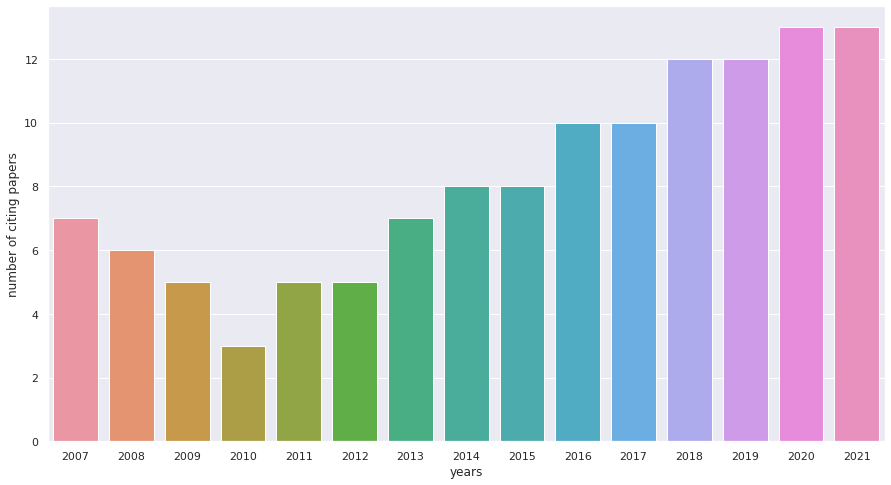

In [ ]:
#citations per year
def cpi(paper) -> None :
  cits = paper['citations']
  years = []
  for i in cits:
    years.append(i.get('year'))
  #print('years', years)
  years = np.array(years)
  (unique, counts) = np.unique(years, return_counts=True)
  sns.set(rc = {'figure.figsize':(15,8)})
  cx = sns.barplot(x = unique, y = counts)
  cx.set(xlabel = 'years', ylabel = 'number of citing papers')
cpi(paper) 

In [ ]:
# API WITH KEYWORDS IN IT
import requests
resp = requests.get('http://api.springernature.com/metadata/json/doi/10.1007/s11276-008-0131-4?api_key=78efc06559822ae52f1e57a4fde9aab6')
print(resp.text)

{"apiMessage":"This JSON was provided by Springer Nature","query":"doi:10.1007/s11276-008-0131-4","apiKey":"78efc06559822ae52f1e57a4fde9aab6","result":[{"total":"1","start":"1","pageLength":"10","recordsDisplayed":"1"}],"records":[{"contentType":"Article","identifier":"doi:10.1007/s11276-008-0131-4","language":"en","url":[{"format":"","platform":"","value":"http://dx.doi.org/10.1007/s11276-008-0131-4"}],"title":"Bit-per-joule performance of power saving ad hoc networks with a mobile backbone","creators":[{ "creator":"Huang, Xiaolong" },{ "creator":"Rubin, Izhak" }],"publicationName":"Wireless Networks","openaccess":"false","doi":"10.1007/s11276-008-0131-4","publisher":"Springer","publicationDate":"2010-02-01","publicationType":"Journal","issn":"1572-8196","volume":"16","number":"2","genre":"OriginalPaper","startingPage":"311","endingPage":"329","journalId":"11276","copyright":"©2008 Springer Science+Business Media, LLC","abstract":"Energy efficient MAC protocols have been developed for

# KEYWORD EXTRACTION

In [ ]:
from nltk import tokenize
from operator import itemgetter
import math
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
abstract = paper['abstract']

# Total Words in the Abstract
total_words = abstract.split()
total_word_length = len(total_words)
print(total_word_length)

# Total Sentences in the Abstract
total_sentences = tokenize.sent_tokenize(abstract)
total_sent_len = len(total_sentences)
print(total_sent_len)


156
7


In [ ]:

# Remove Stop Words
stop_words = set(stopwords.words('english'))
abstract = re.sub(r'[^\w\s]','',abstract)
word_tokens = word_tokenize(abstract) # tokenise the words
words = [w for w in word_tokens if not w.lower() in stop_words] #filter the words
print(words)

['rather', 'nonstandard', 'quantum', 'representation', 'canonical', 'commutation', 'relations', 'quantum', 'mechanics', 'systems', 'known', 'polymer', 'representation', 'gained', 'attention', 'recent', 'years', 'due', 'possible', 'relation', 'Planck', 'scale', 'physics', 'particular', 'approach', 'followed', 'symmetric', 'sector', 'loop', 'quantum', 'gravity', 'known', 'loop', 'quantum', 'cosmology', 'explore', 'different', 'aspects', 'relation', 'ordinary', 'Schroedinger', 'theory', 'polymer', 'description', 'paper', 'two', 'parts', 'first', 'one', 'derive', 'polymer', 'quantum', 'mechanics', 'starting', 'ordinary', 'Schroedinger', 'theory', 'show', 'polymer', 'description', 'arises', 'appropriate', 'limit', 'second', 'part', 'consider', 'continuum', 'limit', 'theory', 'namely', 'reverse', 'process', 'one', 'starts', 'discrete', 'theory', 'tries', 'recover', 'back', 'ordinary', 'Schroedinger', 'quantum', 'mechanics', 'consider', 'several', 'examples', 'interest', 'including', 'harmoni

In [ ]:
# Calculate TF Score

tf_score = {}
for each_word in words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in tf_score:
            tf_score[each_word] += 1
        else:
            tf_score[each_word] = 1

# Dividing by total_word_length for each dictionary element
tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())
print(tf_score)

{'rather': 0.00641025641025641, 'nonstandard': 0.00641025641025641, 'quantum': 0.038461538461538464, 'representation': 0.01282051282051282, 'canonical': 0.00641025641025641, 'commutation': 0.00641025641025641, 'relations': 0.00641025641025641, 'mechanics': 0.019230769230769232, 'systems': 0.00641025641025641, 'known': 0.01282051282051282, 'polymer': 0.02564102564102564, 'gained': 0.00641025641025641, 'attention': 0.00641025641025641, 'recent': 0.00641025641025641, 'years': 0.00641025641025641, 'due': 0.00641025641025641, 'possible': 0.00641025641025641, 'relation': 0.01282051282051282, 'Planck': 0.00641025641025641, 'scale': 0.00641025641025641, 'physics': 0.00641025641025641, 'particular': 0.00641025641025641, 'approach': 0.00641025641025641, 'followed': 0.00641025641025641, 'symmetric': 0.00641025641025641, 'sector': 0.00641025641025641, 'loop': 0.01282051282051282, 'gravity': 0.00641025641025641, 'cosmology': 0.00641025641025641, 'explore': 0.00641025641025641, 'different': 0.006410

In [ ]:
# Function to check if the word is present in a sentence list

def check_sent(word, sentences): 
    final = [all([w in x for w in word]) for x in sentences] 
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))

In [ ]:
# Calculate IDF

idf_score = {}
for each_word in words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in idf_score:
            idf_score[each_word] = check_sent(each_word, total_sentences)
        else:
            idf_score[each_word] = 1

# Performing a log and divide
idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

print(idf_score)

{'rather': 1.9459101490553132, 'nonstandard': 1.9459101490553132, 'quantum': 0.5596157879354227, 'representation': 0.15415067982725836, 'canonical': 1.9459101490553132, 'commutation': 1.9459101490553132, 'relations': 1.9459101490553132, 'mechanics': 0.15415067982725836, 'systems': 1.9459101490553132, 'known': 0.8472978603872037, 'polymer': 0.3364722366212129, 'gained': 1.9459101490553132, 'attention': 1.9459101490553132, 'recent': 1.9459101490553132, 'years': 1.9459101490553132, 'due': 1.9459101490553132, 'possible': 1.9459101490553132, 'relation': 0.15415067982725836, 'Planck': 1.9459101490553132, 'scale': 1.9459101490553132, 'physics': 1.9459101490553132, 'particular': 1.9459101490553132, 'approach': 1.9459101490553132, 'followed': 1.9459101490553132, 'symmetric': 1.9459101490553132, 'sector': 1.9459101490553132, 'loop': 0.15415067982725836, 'gravity': 1.9459101490553132, 'cosmology': 1.9459101490553132, 'explore': 1.9459101490553132, 'different': 1.9459101490553132, 'aspects': 1.945

In [ ]:
tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}
def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
    return result
print(get_top_n(tf_idf_score, 10))


{'quantum': 0.02152368415136241, 'Schroedinger': 0.01629418962283084, 'rather': 0.012473783006764829, 'nonstandard': 0.012473783006764829, 'canonical': 0.012473783006764829, 'commutation': 0.012473783006764829, 'relations': 0.012473783006764829, 'systems': 0.012473783006764829, 'gained': 0.012473783006764829, 'attention': 0.012473783006764829}


### RAKE INBUILT - TRIALS

In [ ]:
#! pip install rake-nltk
#from rake_nltk import Rake
#r = Rake()
#r.extract_keywords_from_text(abstract)
#keywords = r.get_ranked_phrases()


In [ ]:
#rake from scratch trials

from typing import Callable, DefaultDict, Dict, List, Optional, Set, Tuple

# Readability type definitions.
Word = str
Sentence = str
Phrase = Tuple[str, ...]


class Metric(Enum):
    """Different metrics that can be used for ranking."""

    DEGREE_TO_FREQUENCY_RATIO = 0  # Uses d(w)/f(w) as the metric
    WORD_DEGREE = 1  # Uses d(w) alone as the metric
    WORD_FREQUENCY = 2  # Uses f(w) alone as the metric


class Rake:
    """Rapid Automatic Keyword Extraction Algorithm."""

    def __init__(
        self,
        stopwords: Optional[Set[str]] = None,
        punctuations: Optional[Set[str]] = None,
        language: str = 'english',
        ranking_metric: Metric = Metric.DEGREE_TO_FREQUENCY_RATIO,
        max_length: int = 100000,
        min_length: int = 1,
        include_repeated_phrases: bool = True,
        sentence_tokenizer: Optional[Callable[[str], List[str]]] = None,
        word_tokenizer: Optional[Callable[[str], List[str]]] = None,
    ):

        # By default use degree to frequency ratio as the metric.
        if isinstance(ranking_metric, Metric):
            self.metric = ranking_metric
        else:
            self.metric = Metric.DEGREE_TO_FREQUENCY_RATIO

        # If stopwords not provided we use language stopwords by default.
        self.stopwords: Set[str]
        if stopwords:
            self.stopwords = stopwords
        else:
            self.stopwords = set(nltk.corpus.stopwords.words(language))

        # If punctuations are not provided we ignore all punctuation symbols.
        self.punctuations: Set[str]
        if punctuations:
            self.punctuations = punctuations
        else:
            self.punctuations = set(string.punctuation)

        # All things which act as sentence breaks during keyword extraction.
        self.to_ignore: Set[str] = set(chain(self.stopwords, self.punctuations))

        # Assign min or max length to the attributes
        self.min_length: int = min_length
        self.max_length: int = max_length

        # Whether we should include repeated phreases in the computation or not.
        self.include_repeated_phrases: bool = include_repeated_phrases

        # Tokenizers.
        self.sentence_tokenizer: Callable[[str], List[str]]
        if sentence_tokenizer:
            self.sentence_tokenizer = sentence_tokenizer
        else:
            self.sentence_tokenizer = nltk.tokenize.sent_tokenize
        self.word_tokenizer: Callable[[str], List[str]]
        if word_tokenizer:
            self.word_tokenizer = word_tokenizer
        else:
            self.word_tokenizer = nltk.tokenize.wordpunct_tokenize

        # Stuff to be extracted from the provided text.
        self.frequency_dist: Dict[Word, int]
        self.degree: Dict[Word, int]
        self.rank_list: List[Tuple[float, Sentence]]
        self.ranked_phrases: List[Sentence]

    def extract_keywords_from_text(self, text: str):
        sentences: List[Sentence] = self._tokenize_text_to_sentences(text)
        self.extract_keywords_from_sentences(sentences)

    def extract_keywords_from_sentences(self, sentences: List[Sentence]):
        phrase_list: List[Phrase] = self._generate_phrases(sentences)
        self._build_frequency_dist(phrase_list)
        self._build_word_co_occurance_graph(phrase_list)
        self._build_ranklist(phrase_list)

    def get_ranked_phrases(self) -> List[Sentence]:
        return self.ranked_phrases


    def _tokenize_text_to_sentences(self, text: str) -> List[Sentence]:
        """Tokenizes the given text string into sentences using the configured
        sentence tokenizer. Configuration uses `nltk.tokenize.sent_tokenize`
        by default.
        :param text: String text to tokenize into sentences.
        :return: List of sentences as per the tokenizer used.
        """
        return self.sentence_tokenizer(text)

    def _tokenize_sentence_to_words(self, sentence: Sentence) -> List[Word]:
        """Tokenizes the given sentence string into words using the configured
        word tokenizer. Configuration uses `nltk.tokenize.wordpunct_tokenize`
        by default.
        :param sentence: String sentence to tokenize into words.
        :return: List of words as per the tokenizer used.
        """
        return self.word_tokenizer(sentence)

    def _build_frequency_dist(self, phrase_list: List[Phrase]) -> None:
        self.frequency_dist = Counter(chain.from_iterable(phrase_list))

    def _build_word_co_occurance_graph(self, phrase_list: List[Phrase]) -> None:
        co_occurance_graph: DefaultDict[Word, DefaultDict[Word, int]] = defaultdict(lambda: defaultdict(lambda: 0))
        for phrase in phrase_list:
            # For each phrase in the phrase list, count co-occurances of the
            # word with other words in the phrase.
            #
            # Note: Keep the co-occurances graph as is, to help facilitate its
            # use in other creative ways if required later.
            for (word, coword) in product(phrase, phrase):
                co_occurance_graph[word][coword] += 1
        self.degree = defaultdict(lambda: 0)
        for key in co_occurance_graph:
            self.degree[key] = sum(co_occurance_graph[key].values())

    def _build_ranklist(self, phrase_list: List[Phrase]):
        """Method to rank each contender phrase using the formula
              phrase_score = sum of scores of words in the phrase.
              word_score = d(w) or f(w) or d(w)/f(w) where d is degree
                           and f is frequency.
        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        self.rank_list = []
        for phrase in phrase_list:
            rank = 0.0
            for word in phrase:
                if self.metric == Metric.DEGREE_TO_FREQUENCY_RATIO:
                    rank += 1.0 * self.degree[word] / self.frequency_dist[word]
                elif self.metric == Metric.WORD_DEGREE:
                    rank += 1.0 * self.degree[word]
                else:
                    rank += 1.0 * self.frequency_dist[word]
            self.rank_list.append((rank, ' '.join(phrase)))
        self.rank_list.sort(reverse=True)
        self.ranked_phrases = [ph[1] for ph in self.rank_list]

    def _generate_phrases(self, sentences: List[Sentence]) -> List[Phrase]:
        phrase_list: List[Phrase] = []
        # Create contender phrases from sentences.
        for sentence in sentences:
            word_list: List[Word] = [word.lower() for word in self._tokenize_sentence_to_words(sentence)]
            phrase_list.extend(self._get_phrase_list_from_words(word_list))

        # Based on user's choice to include or not include repeated phrases
        # we compute the phrase list and return it. If not including repeated
        # phrases, we only include the first occurance of the phrase and drop
        # the rest.
        if not self.include_repeated_phrases:
            unique_phrase_tracker: Set[Phrase] = set()
            non_repeated_phrase_list: List[Phrase] = []
            for phrase in phrase_list:
                if phrase not in unique_phrase_tracker:
                    unique_phrase_tracker.add(phrase)
                    non_repeated_phrase_list.append(phrase)
            return non_repeated_phrase_list

        return phrase_list

    def _get_phrase_list_from_words(self, word_list: List[Word]) -> List[Phrase]:
        groups = groupby(word_list, lambda x: x not in self.to_ignore)
        phrases: List[Phrase] = [tuple(group[1]) for group in groups if group[0]]
        return list(filter(lambda x: self.min_length <= len(x) <= self.max_length, phrases))

In [ ]:
r = Rake()
r.extract_keywords_from_text(abstract)
keywords = r.get_ranked_phrases()

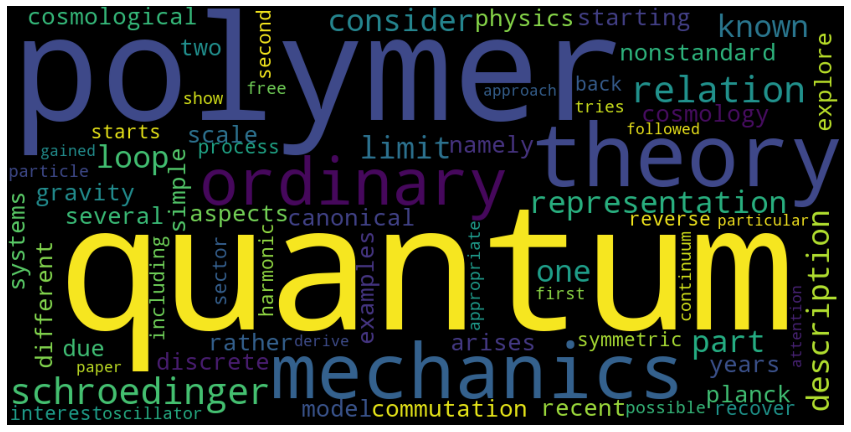

In [ ]:
# WORDCLOUD TRIAL
'''import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(abstract)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()'''

#wordclud from list
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(keywords)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()